# Disclaimer
This material was prepared as an account of work sponsored by an agency of the United States Government.  Neither the United States Government nor the United States Department of Energy, nor Battelle, nor any of their employees, nor any jurisdiction or organization that has cooperated in the development of these materials, makes any warranty, express or implied, or assumes any legal liability or responsibility for the accuracy, completeness, or usefulness or any information, apparatus, product, software, or process disclosed, or represents that its use would not infringe privately owned rights. Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise does not necessarily constitute or imply its endorsement, recommendation, or favoring by the United States Government or any agency thereof, or Battelle Memorial Institute. The views and opinions of authors expressed herein do not necessarily state or reflect those of the United States Government or any agency thereof.

PACIFIC NORTHWEST NATIONAL LABORATORY operated by BATTELLE for the UNITED STATES DEPARTMENT OF ENERGY under Contract DE-AC05-76RL01830.

In [1]:
from pathlib import Path

import datasets
import matplotlib.pyplot as plt
import numpy as np
import umap
import pandas as pd
from tqdm.auto import tqdm

from nukelm.analyze.BERTopic import BERTopic
from nukelm.analyze.umap_comparisons import PLOT_KWARGS, UMAP_KWARGS, plot_points


PROJECT_DIR = Path.cwd().parent
output_dir = PROJECT_DIR / "data" / "08_reporting" / "bertopic-mass-spec"
output_dir.mkdir(exist_ok=True)

AGG_METHOD = "CLS"

transformers version (4.10.2) does not match run_glue script version (4.8.1)
transformers version (4.10.2) does not match run_mlm script version (4.8.1)


In [2]:
embeddings = np.load(PROJECT_DIR.parent / "mass-spec-cleaned-output" / "binary-embeddings.npy")

In [3]:
dataset = datasets.load_from_disk(str(PROJECT_DIR.parent / "mass-spec-cleaned-output"))


In [4]:
nuke_dataset = dataset.filter(lambda x: x['Binary Label'] == 1)


Loading cached processed dataset at C:/Users/burk640/OneDrive - PNNL/Desktop/DUDE/mass-spec-cleaned-output\cache-14bd4bd84f66a481.arrow


In [5]:
idx = [i for i, label in enumerate(dataset['Binary Label']) if label == 1]
nuke_embeddings = embeddings[idx, :]

# BERTopic applied to all data


In [6]:
BERTOPIC_KWARGS = {
    "n_neighbors": 25,
    "n_components": 100,
    "min_dist": 0.1,
    "umap_metric": "euclidean",
    "random_state": 42,
    "min_cluster_size": 25,
    "min_samples": None,
    "cluster_selection_epsilon": 0.0,
    "hdbscan_metric": "euclidean",
    "alpha": 1.0,
    "cluster_selection_method": "eom",
    "verbose": True,
    "vectorizer_kwargs": {"n_gram_range": (1, 3), "stop_words": "english"},
}

In [7]:
model = BERTopic(**BERTOPIC_KWARGS)
labels, _ = model.fit_transform(dataset["text"], embeddings)


Overriding parameter 'n_gram_range' with value form 'vectorizer_kwargs'.


In [8]:
nuke_model = BERTopic(**BERTOPIC_KWARGS)
nuke_labels, _ = nuke_model.fit_transform(nuke_dataset["text"], nuke_embeddings)


In [9]:
labels_set = set(labels + nuke_labels)
label_map = {i: f"Cluster {i + 1: 2d}" for i in range(max(labels_set) + 1)}
label_map[-1] = "None"

In [10]:
topics = []
for i in set(labels):
    _label = f"Cluster {i+1}" if i + 1 > 0 else "None"
    n_grams, scores  = [_ for _ in zip(*model.get_topic(i))]
    _topics = {(_label, "n-gram"): list(n_grams), (_label, "score"): list(scores)}
    topics.append(pd.DataFrame(_topics))
topics_df = pd.concat(topics, axis=1)
# topics_df.to_csv(output_dir / "all-topics.csv", index=False)
topics_df

Cluster 1                        Cluster 2            \
               n-gram     score                 n-gram     score   
0              method  0.009447                 method  0.010768   
1                mass  0.007304               analysis  0.007901   
2             samples  0.007074                   mass  0.007026   
3        spectrometry  0.006936           spectrometry  0.006933   
4            analysis  0.006625                  using  0.006390   
5               using  0.006538                 liquid  0.006265   
6           precision  0.006393      mass spectrometry  0.006213   
7   mass spectrometry  0.006045              compounds  0.006151   
8       determination  0.005535          determination  0.006105   
9          extraction  0.005153              precision  0.006091   
10          detection  0.004831                   acid  0.005972   
11             liquid  0.004622                samples  0.005780   
12             sample  0.004556         quantification  0.005625   
13               used  0.004313              detection  0.005489   
14          developed  0.004132         chromatography  0.005476   
15            results  0.004120              different  0.005114   
16     quantification  0.004119             extraction  0.005012   
17           accuracy  0.004101              developed  0.004888   
18           standard  0.004034             pesticides  0.004744   
19              range  0.003762  liquid chromatography  0.004659   
20            isotope  0.003750                   used  0.004619   
21               high  0.003711              linearity  0.004516   
22             plasma  0.003678                results  0.004473   
23     chromatography  0.003612                quality  0.004221   
24            coupled  0.003601                coupled  0.003850   
25         analytical  0.003439              validated  0.003834   
26               acid  0.003434           quantitative  0.003765   
27       respectively  0.003426                 limits  0.003745   
28              study  0.003362           simultaneous  0.003715   
29          compounds  0.003271                  plant  0.003695   

            Cluster 3                    Cluster 4            \
               n-gram     score             n-gram     score   
0               water  0.020090              urine  0.026707   
1              method  0.011460        human urine  0.012184   
2             samples  0.010556             method  0.010982   
3          extraction  0.010300              human  0.010448   
4       water samples  0.008538      urine samples  0.010137   
5       determination  0.008213            samples  0.008892   
6        spectrometry  0.007615            urinary  0.008327   
7           detection  0.006878           exposure  0.008008   
8          wastewater  0.006811        metabolites  0.007977   
9           compounds  0.006789       spectrometry  0.007196   
10                 l1  0.006777               mass  0.006890   
11           analysis  0.006656          detection  0.006737   
12               mass  0.006372           analysis  0.006650   
13              using  0.006337  mass spectrometry  0.006385   
14          precision  0.006143              using  0.006242   
15             limits  0.006092      determination  0.006000   
16  mass spectrometry  0.006039         extraction  0.005807   
17           drinking  0.005975             liquid  0.005686   
18      environmental  0.005775          precision  0.005483   
19                 ng  0.005541          developed  0.005172   
20     drinking water  0.005348               acid  0.004873   
21                gas  0.005289             sample  0.004852   
22            surface  0.005231     quantification  0.004512   
23             sample  0.005096           accuracy  0.004484   
24                ngl  0.004794               ngml  0.004350   
25              range  0.004652     chromatography  0.004290   
26           standard  0.004629            

<ipython-input-11-49437ad1c29a>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 6))


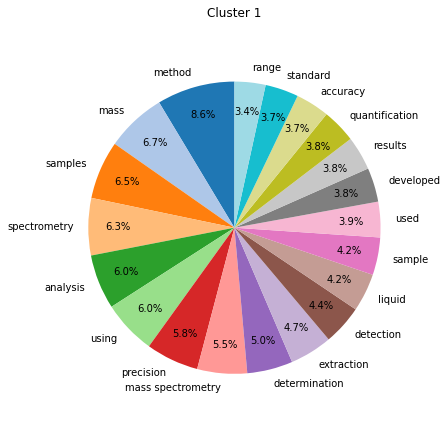

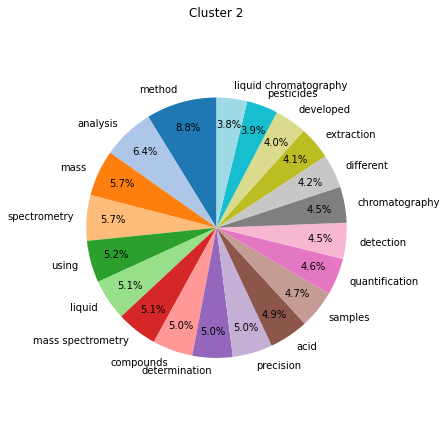

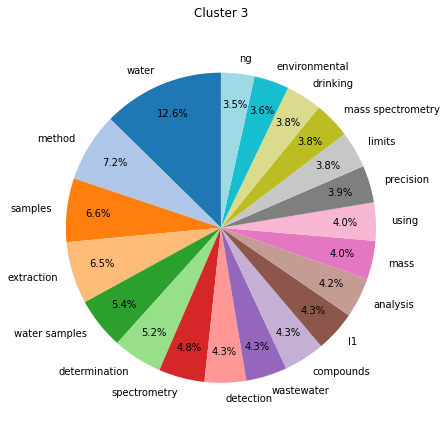

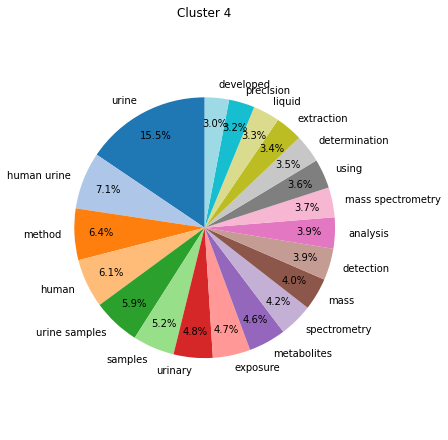

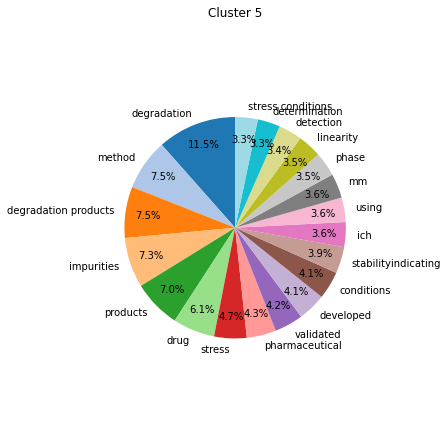

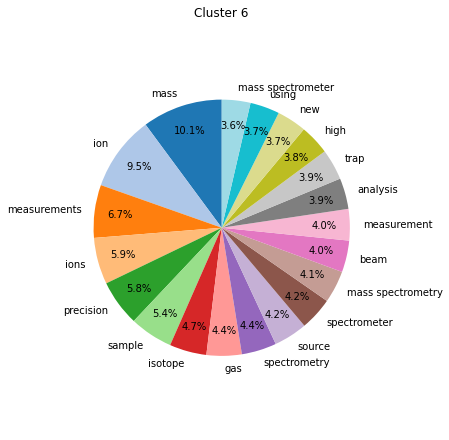

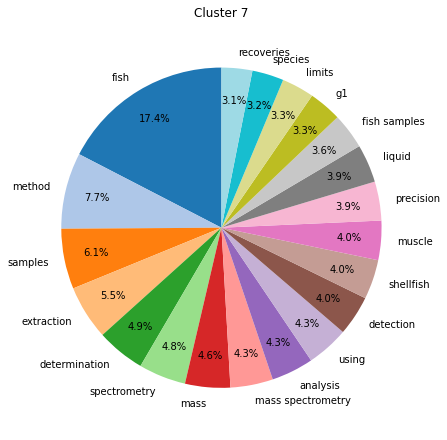

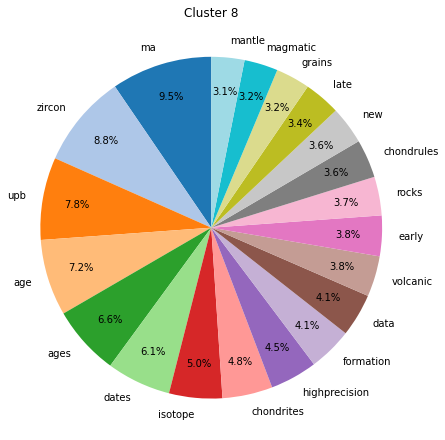

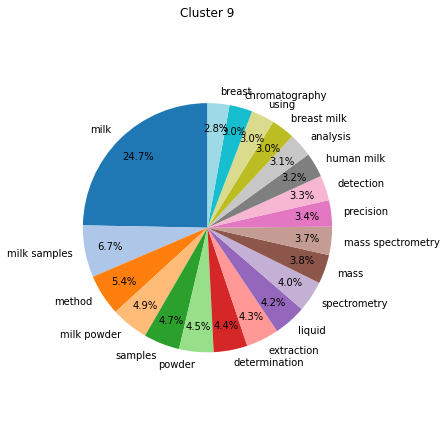

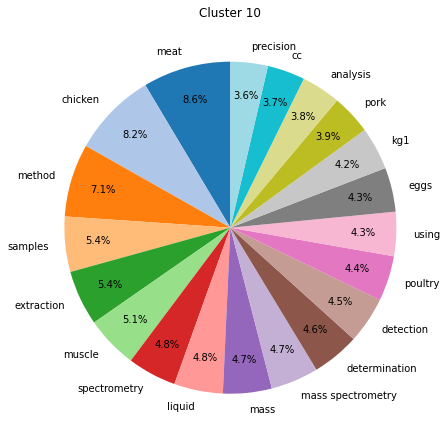

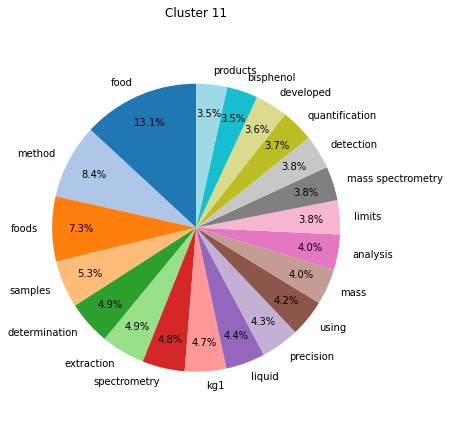

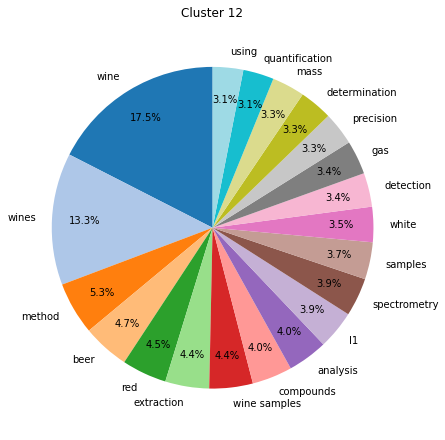

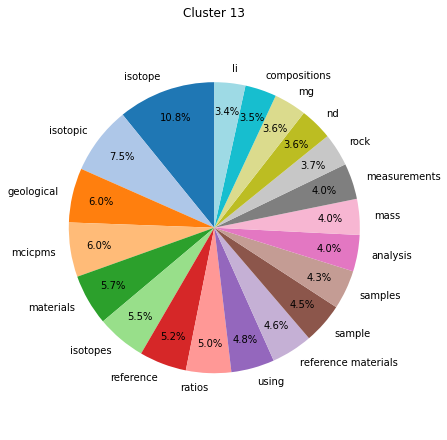

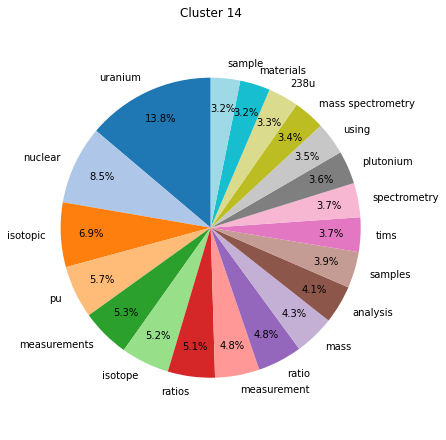

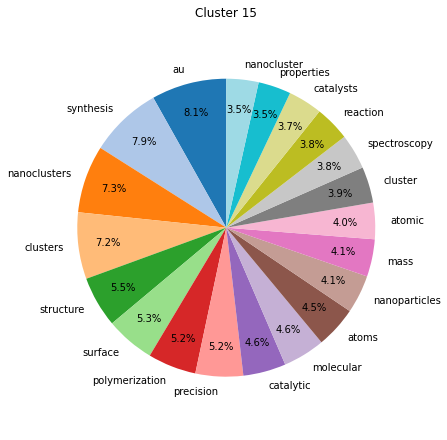

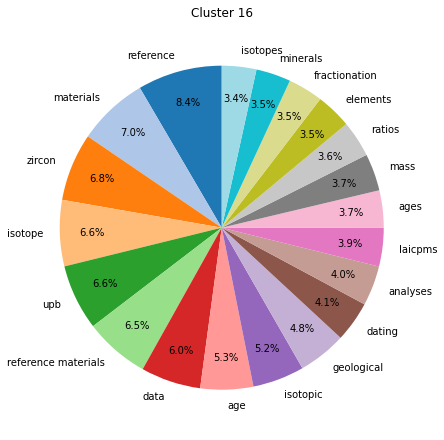

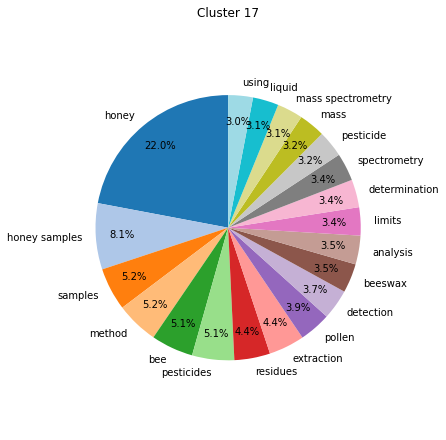

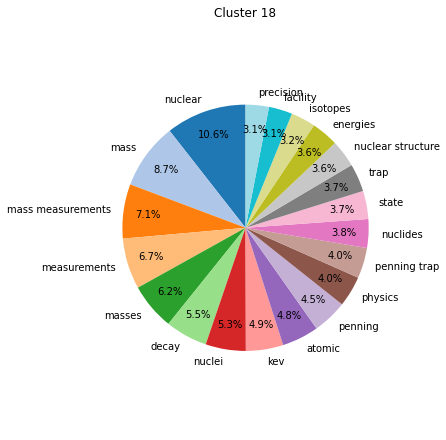

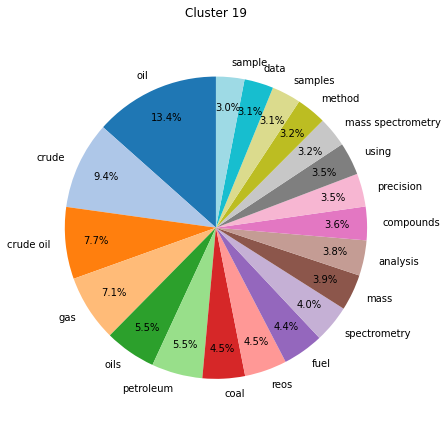

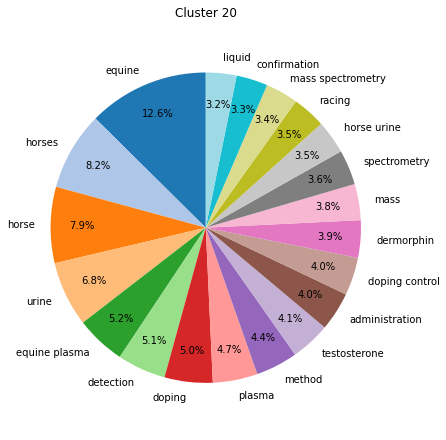

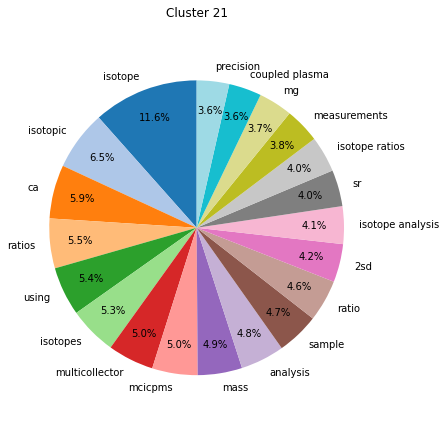

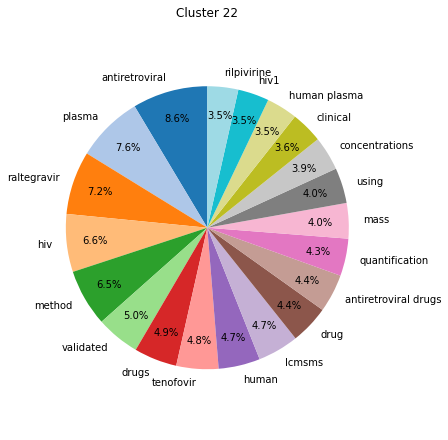

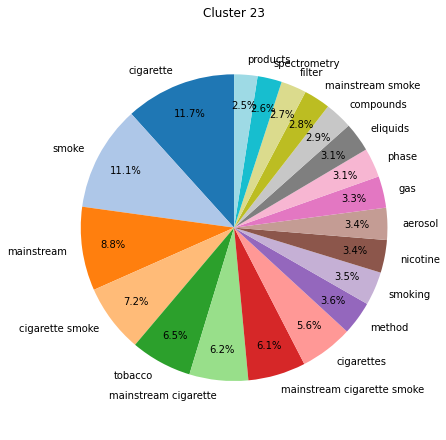

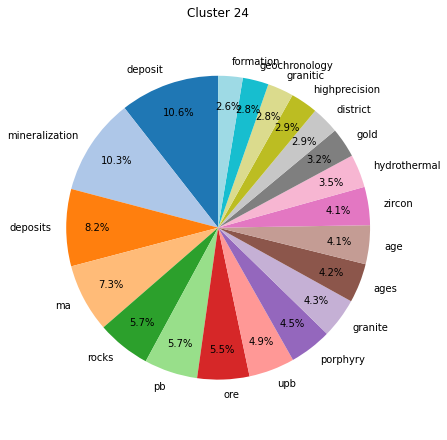

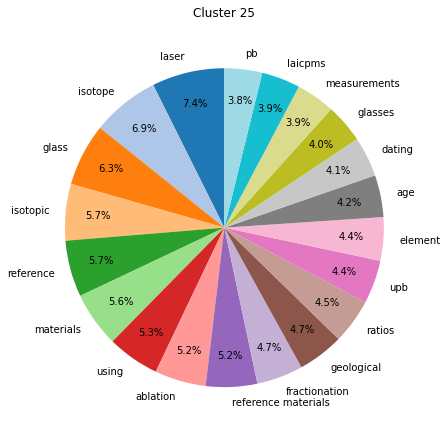

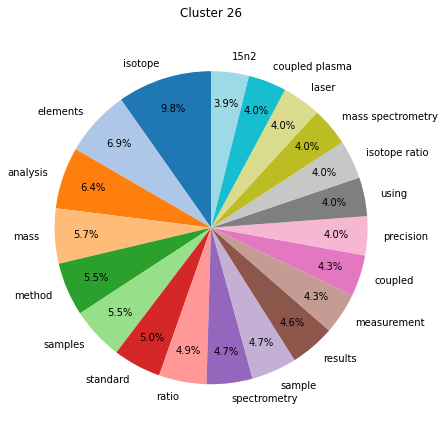

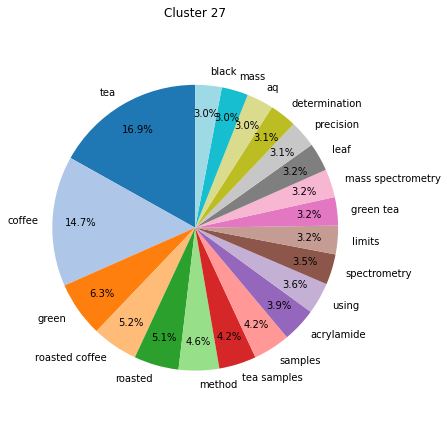

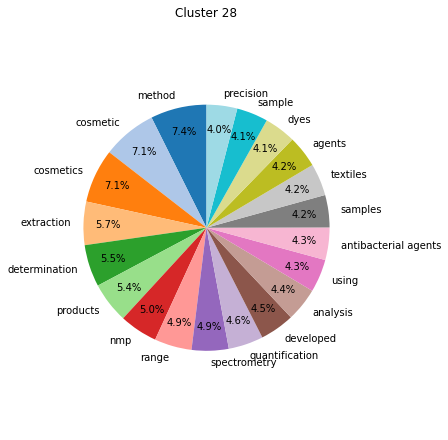

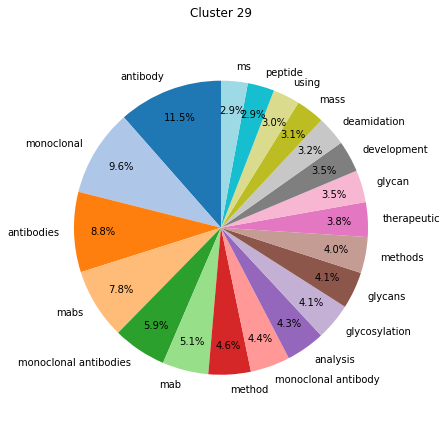

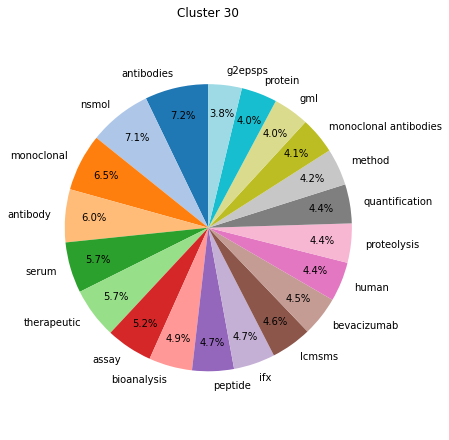

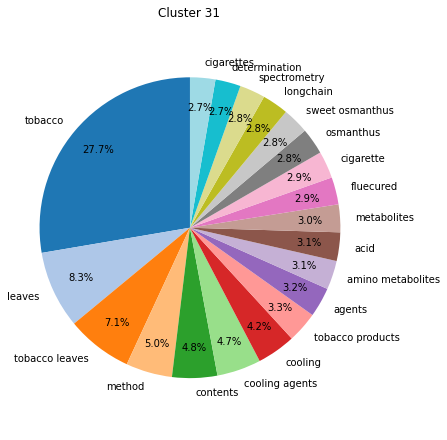

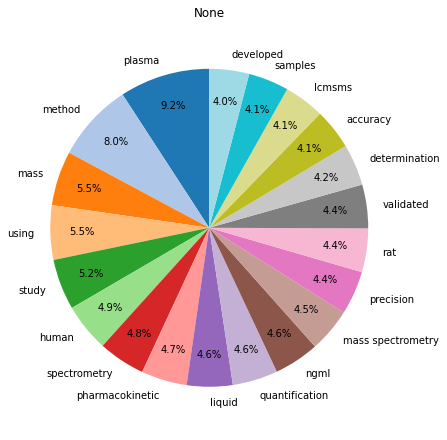

In [11]:
n_topics = 20
cmap = plt.get_cmap("tab20")
colors = cmap(range(n_topics))

cluster_names = [cluster for i, (cluster, _) in enumerate(topics_df.columns) if i % 2 == 0]
for cluster in tqdm(cluster_names):
    n_grams = topics_df.loc[:, pd.IndexSlice[cluster, "n-gram"]].iloc[:n_topics]
    scores = topics_df.loc[:, pd.IndexSlice[cluster, "score"]].iloc[:n_topics]

    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 6))
    ax.pie(scores, labels=n_grams, autopct='%1.1f%%', pctdistance=0.8, startangle=90, normalize=True, colors=colors)
    ax.axis('equal')
    ax.set_title(cluster)
#     fig.savefig(output_dir / "topic_wheels" / f"{cluster.replace(' ', '_').lower()}.png", dpi=150)
#     plt.close(fig)


In [12]:
nuke_topics = []
for i in set(nuke_labels):
    _label = f"Cluster {i+1}" if i + 1 > 0 else "None"
    n_grams, scores  = [_ for _ in zip(*nuke_model.get_topic(i))]
    _topics = {(_label, "n-gram"): list(n_grams), (_label, "score"): list(scores)}
    nuke_topics.append(pd.DataFrame(_topics))
nuke_topics_df = pd.concat(nuke_topics, axis=1)
# nuke_topics_df.to_csv(output_dir / "nuke-topics.csv")
nuke_topics_df

Cluster 1                    Cluster 2            \
               n-gram     score             n-gram     score   
0                mass  0.044217               mass  0.037336   
1             nuclear  0.031178       measurements  0.023958   
2        measurements  0.021717          precision  0.018061   
3           precision  0.018388                ion  0.014713   
4   mass measurements  0.018265  mass measurements  0.014625   
5        spectrometry  0.017227           isotopes  0.014592   
6   mass spectrometry  0.016908       spectrometry  0.014446   
7               decay  0.016552            nuclear  0.014001   
8              masses  0.016015           measured  0.013679   
9              nuclei  0.014733                cec  0.013243   
10                kev  0.013119             nuclei  0.012914   
11                new  0.012732              using  0.012713   
12             values  0.011904        measurement  0.012452   
13           nuclides  0.011563               trap  0.012304   
14          structure  0.011431  mass spectrometry  0.012261   
15             atomic  0.011304            penning  0.011672   
16              state  0.011180         separation  0.011594   
17              using  0.010916          performed  0.010803   
18       experimental  0.010881           electron  0.010644   
19            physics  0.010796               rare  0.010043   
20      highprecision  0.010284             masses  0.010008   
21           energies  0.010262             charge  0.009403   
22               data  0.009978             exotic  0.009294   
23  nuclear structure  0.009976               used  0.008855   
24           measured  0.009966           produced  0.008852   
25               trap  0.009604                new  0.008817   
26            penning  0.009525       penning trap  0.008814   
27           isotopes  0.009492               ions  0.008775   
28              shell  0.009175                rfq  0.008310   
29            results  0.009168      rare isotopes  0.008310   

                 None            
               n-gram     score  
0                mass  0.023083  
1                 ion  0.015171  
2           precision  0.013944  
3        measurements  0.013547  
4        spectrometry  0.013056  
5   mass spectrometry  0.012080  
6            analysis  0.011891  
7               using  0.011361  
8             samples  0.010691  
9             isotope  0.010554  
10             method  0.010260  
11        measurement  0.009884  
12           isotopic  0.009459  
13             sample  0.009384  
14               high  0.009230  
15                new  0.008889  
16                gas  0.007985  
17              ratio  0.007878  
18                ams  0.007758  
19             source  0.007742  
20           measured  0.007313  
21            uranium  0.007198  
22            nuclear  0.007171  
23            results  0.006997  
24       spectrometer  0.006845  
25             ratios  0.006763  
26               ions  0.006702  
27           detector  0.006362  
28           standard  0.006308  
29               data  0.006292

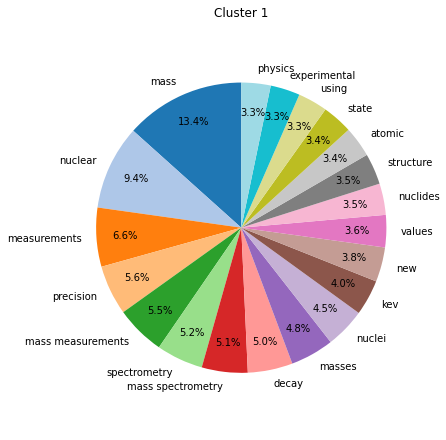

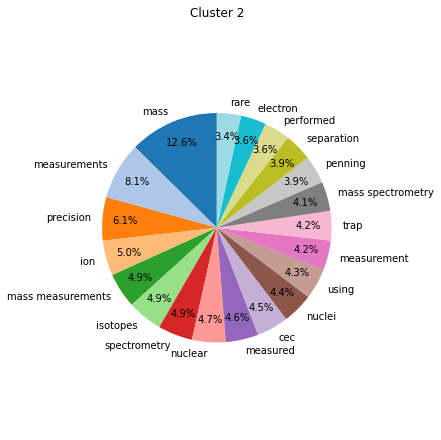

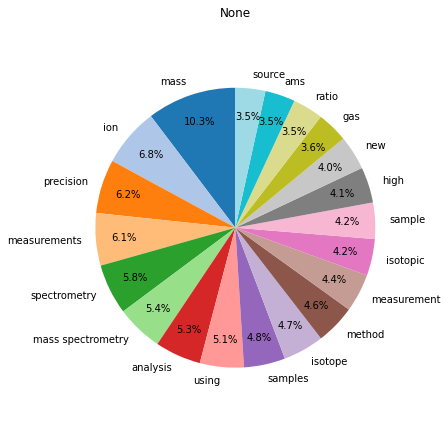

In [13]:
cluster_names = [cluster for i, (cluster, _) in enumerate(nuke_topics_df.columns) if i % 2 == 0]
for cluster in tqdm(cluster_names):
    n_grams = nuke_topics_df.loc[:, pd.IndexSlice[cluster, "n-gram"]].iloc[:n_topics]
    scores = nuke_topics_df.loc[:, pd.IndexSlice[cluster, "score"]].iloc[:n_topics]

    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 6))
    ax.pie(scores, labels=n_grams, autopct='%1.1f%%', pctdistance=0.8, startangle=90, normalize=True, colors=colors)
    ax.axis('equal')
    ax.set_title(cluster)
#     fig.savefig(output_dir / "nuke_topic_wheels" / f"{cluster.replace(' ', '_').lower()}.png", dpi=150)
#     plt.close(fig)

In [146]:
# abstracts = pd.read_csv(PROJECT_DIR / "notebooks" / "mass-spec-cleaned.csv", index_col=0)
# abstracts["All Abstracts Cluster ID"] = [f"Cluster {i+1}" if i + 1 > 0 else "None" for i in labels]
# abstracts["Nuke Abstracts Cluster ID"] = float("nan")
# abstracts.loc[np.array(dataset["Binary Label"]) == 1, "Nuke Abstracts Cluster ID"] = [f"Cluster {i+1}" if i + 1 > 0 else "None" for i in nuke_labels]
# abstracts.to_csv(output_dir / "mass-spec-clusters.csv")

# Plotting

In [14]:
same_mapper = True

In [15]:
mapper = umap.UMAP(**UMAP_KWARGS).fit(embeddings)

if same_mapper:
    nuke_mapper = mapper
else:
    nuke_mapper = umap.UMAP(**UMAP_KWARGS).fit(nuke_embeddings)

points = mapper.transform(embeddings)
nuke_points = nuke_mapper.transform(nuke_embeddings)

In [16]:
PLOT_KWARGS = {
    "linestyle": "None",
    "marker": ".",
    "alpha": 0.5,
}


In [17]:
_labels = [label if label >= 0 else int(1e5) for label in labels]
_nuke_labels = [label if label >= 0 else int(1e5) for label in nuke_labels]

In [18]:
labels_set = (set(labels + nuke_labels) - {-1}).union({int(1e5)})
label_map = {i: f"Cluster {i + 1:d}" for i in labels_set}

label_map[int(1e5)] = "Outlier"


In [19]:
# points = (points_trained_1, points_ots_1)[::-1]
# labels = ((dataset_trained_1["label"], dataset_ots_1["label"])[::-1], (_labels_trained_1, _labels_ots_1)[::-1])
# label_maps = (LABEL_MAP, label_map_1)
titles = ("All Articles", "NFC-Related Articles")

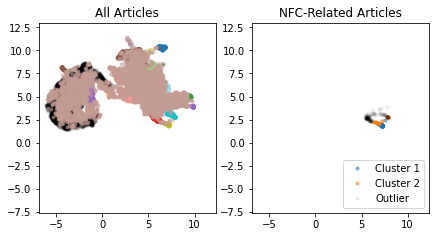

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

_mins, _maxs = [], []

ax = axes[0]
_cmap = plt.get_cmap("tab20")
def cmap(x):
    _x = x % 18
    if _x < 14:
        return _cmap(x)
    else:
        return _cmap(x+2)
unique_labels = sorted(list(set(_labels)))
for j, class_idx in enumerate(unique_labels[::-1]):
    idx = [i for i, label in enumerate(_labels) if label == class_idx]
    class_name = label_map[class_idx]
    if class_name != "Outlier":
        ax.plot(
            points[idx, 0],
            points[idx, 1],
            label=class_name,
            color=cmap(j % 20),
            **PLOT_KWARGS,
        )
    else:
        ax.plot(
            points[idx, 0],
            points[idx, 1],
            label=class_name,
            color="k",
            alpha=0.05,
            **{k: v for k, v in PLOT_KWARGS.items() if k not in {"color", "alpha"}},
        )
ax.set_title(titles[0])
# ax.legend(loc="upper right")

_ymin, _ymax = ax.get_ylim()
_mins.append(_ymin)
_maxs.append(_ymax)
_xmin, _xmax = ax.get_xlim()
_mins.append(_xmin)
_maxs.append(_xmax)


ax = axes[1]
cmap = plt.get_cmap("tab10")
unique_labels = sorted(list(set(_nuke_labels)))
idx = {}
for j, class_idx in enumerate(unique_labels):
    idx = [i for i, label in enumerate(_nuke_labels) if label == class_idx]
    class_name = label_map[class_idx]
    if class_name != "Outlier":
        ax.plot(
            nuke_points[idx, 0],
            nuke_points[idx, 1],
            label=class_name,
            color=cmap(j % 20),
            **PLOT_KWARGS,
        )
    else:
        ax.plot(
            nuke_points[idx, 0],
            nuke_points[idx, 1],
            label=class_name,
            color="k",
            alpha=0.05,
            **{k: v for k, v in PLOT_KWARGS.items() if k not in {"color", "alpha"}},
        )
ax.set_title(titles[1])
ax.legend(loc="lower right")

_ymin, _ymax = ax.get_ylim()
_mins.append(_ymin)
_maxs.append(_ymax)
_xmin, _xmax = ax.get_xlim()
_mins.append(_xmin)
_maxs.append(_xmax)


_min = min(_mins) * 1.1
_max = max(_maxs) * 1.1
for ax in axes:
    ax.axis("equal")
    ax.set_ylim((_min, _max))
    ax.set_xlim((_min, _max))

In [249]:
# if same_mapper:
#     fig.savefig(output_dir / "mass-spec-clusters-same-mapper.png", dpi=150, bbox_inches="tight")
# else:
#     fig.savefig(output_dir / "mass-spec-clusters.png", dpi=150, bbox_inches="tight")